In [1]:
setwd(here::here())

In [2]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("tgstat")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")
library('RColorBrewer')


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.2      v dplyr   1.0.10
v tidyr   1.2.0      v stringr 1.4.0 
v readr   2.1.0      v forcats 1.0.0 
v purrr   0.3.4      

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x purrr::transpose() masks data.table::transpose()
x tidyr::unpack()    masks Matrix::unpack()



In [3]:
source("scripts/manifold_2d_proj_hr.R")
scdb_init("scrna_db/", force_reinit=T)

fig_dir <- "figs/"
if(!dir.exists(fig_dir)) dir.create(fig_dir)
scfigs_init(fig_dir)

################## WT data #################

mat_id <- "exe"
mc_id <- "exe"

mat <- scdb_mat(mat_id)
mc <- scdb_mc(mc_id)
gset = scdb_gset("exe")
mc2d <- scdb_mc2d(id = "exe_umap")
md <- mat@cell_metadata

mat_emb <- scdb_mat("emb")
mc_emb <- scdb_mc("emb")
mc2d_emb <- scdb_mc2d("emb_umap")
md_emb <- mat_emb@cell_metadata[names(mc_emb@mc),]

mat_embexe <- scdb_mat("embexe")
mc_embexe <- scdb_mc("embexe_recolored")
md_embexe <- mat_embexe@cell_metadata[names(mc_embexe@mc),]

initializing scdb to scrna_db/



In [4]:
################## ELF5 data #################
load("data/elf5_embexe/color_annotation/cmp_annot.Rda")

mat_elf5 = scdb_mat("elf5")
md_elf5 <- mat_elf5@cell_metadata[names(cmp_annot$query_cls_col),]

ko_embs <- c("elf5_exp6_KO_m1e1","elf5_exp4_m1e2","elf5_exp6_KO_m2e3","elf5_ko_exp8_e12")

ko_cls <- rownames(md_elf5)[md_elf5$embryo %in% ko_embs]
ko_cls <- ko_cls[ko_cls %in% names(cmp_annot$query_cls_col)]

elf5_annotations <- data.frame(embryo = md_elf5[names(cmp_annot$query_cls_col),"embryo"],
                               cell_type_color = array(cmp_annot$query_cls_col),
                               row.names = names(cmp_annot$query_cls_col))

In [5]:
plot_size <- function(w,h){
    options(repr.plot.width=w, repr.plot.height=h)
}

In [6]:
exe_cells = colnames(mat@mat)[mat@cell_metadata[colnames(mat@mat),"Experiment"] != "Wildtype project"]
exe_cells_f = exe_cells[!is.na(md[exe_cells,"time_bin"])]

rank_vs_ct = table(mc@colors[mc@mc[exe_cells_f]],mat@cell_metadata[exe_cells_f,"transcriptional_rank"])
rank_vs_ct = rank_vs_ct[mc@color_key$color,]
rank_vs_ct = t(t(rank_vs_ct)/colSums(rank_vs_ct))

emb_age_df = unique(mat@cell_metadata[exe_cells_f,c("embryo","transcriptional_rank",
                                                    "time_bin","developmental_time")])
emb_age_df = emb_age_df[order(emb_age_df$transcriptional_rank),]

sum_age_exe <- emb_age_df %>% 
  group_by(time_bin) %>% 
  summarise(mean=round(mean(developmental_time),1))
sum_age_exe <- as.data.frame(sum_age_exe)

sc_time_annot = data.frame(cell = exe_cells_f,
                           embryo = mat@cell_metadata[exe_cells_f,"embryo"])
sc_time_annot = left_join(sc_time_annot,emb_age_df,by = "embryo")
f = !is.na(sc_time_annot$developmental_time)
sc_time = sc_time_annot$developmental_time[f]
names(sc_time) = sc_time_annot$cell[f]

col_to_ct =  mc@color_key$group
names(col_to_ct) = mc@color_key$color
ct_to_col = mc@color_key$color
names(ct_to_col) = mc@color_key$group

col_to_rank = c(1:nrow(mc@color_key))
names(col_to_rank) = mc@color_key$color
mc_time = tapply(sc_time,mc@mc[names(sc_time)],mean)
mc_new_ord = as.numeric(names(mc_time[order(as.numeric(mc_time))]))

shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_reds <- colorRampPalette(RColorBrewer::brewer.pal(9,"Reds"))(100)
shades_yellows <- colorRampPalette(RColorBrewer::brewer.pal(9,"YlOrBr"))(100)
shades_greys <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greys"))(100)
shades_greens <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greens"))(100)
shades_purples <- colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100)

annotation_col = data.frame(ct = col_to_ct[mc@colors],stringsAsFactors = F)
rownames(annotation_col) = c(1:nrow(annotation_col))
annotation_colors = list(ct = ct_to_col)

In [7]:
chorion_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[1]]
tsc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[2]]
tsc2_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[3]]
spt_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[4]]
epc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[5]]
tgc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[6]]
ptgc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[7]]
spa_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[8]]

chorion_mcs = which(mc@colors == mc@color_key$color[1])
tsc_mcs = which(mc@colors == mc@color_key$color[2])
tsc2_mcs = which(mc@colors == mc@color_key$color[3])
spt_mcs = which(mc@colors == mc@color_key$color[4])
epc_mcs = which(mc@colors == mc@color_key$color[5])
tgc_mcs = which(mc@colors == mc@color_key$color[6])
ptgc_mcs = which(mc@colors == mc@color_key$color[7])
spa_mcs = which(mc@colors == mc@color_key$color[8])

chorion_mcs_ord = mc_new_ord[which(mc_new_ord %in% chorion_mcs)]
tsc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc_mcs)]
tsc2_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc2_mcs)]
spt_mcs_ord = mc_new_ord[which(mc_new_ord %in% spt_mcs)]
epc_mcs_ord = mc_new_ord[which(mc_new_ord %in% epc_mcs)]
tgc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tgc_mcs)]
ptgc_mcs_ord = mc_new_ord[which(mc_new_ord %in% ptgc_mcs)]
spa_mcs_ord = mc_new_ord[which(mc_new_ord %in% spa_mcs)]

mcs_all <- c(tsc_mcs_ord,tsc2_mcs_ord,chorion_mcs_ord,spt_mcs_ord,epc_mcs_ord,tgc_mcs_ord,spa_mcs_ord,ptgc_mcs_ord)
mcs_epc_lineage <- c(tgc_mcs_ord,epc_mcs_ord,spt_mcs_ord)
mcs_chorion_lineage <- c(tsc_mcs_ord,chorion_mcs_ord,tsc2_mcs_ord)

## EDF 7-a

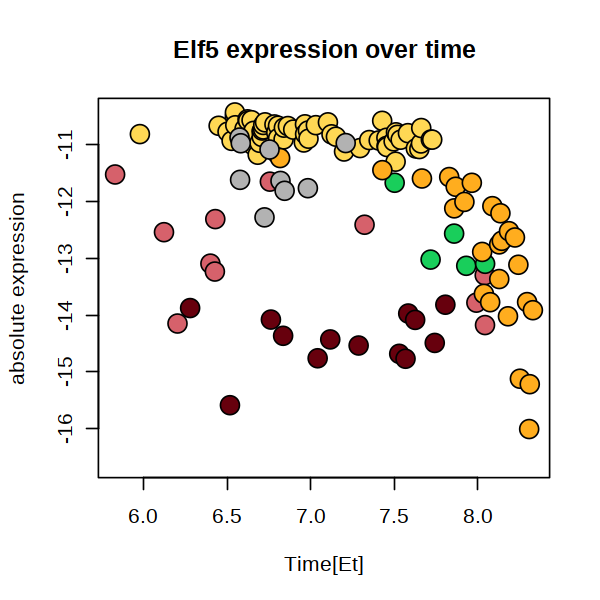

In [8]:
plot_size(5,5)

mcs_to_plot <- c(mcs_epc_lineage,mcs_chorion_lineage)

# pdf("figs/EDF7a.pdf",width = 6, height = 4, useDingbats = F)
plot(x = mc_time[mcs_to_plot], 
     y = log2(mc@e_gc["Elf5",names(mc_time[mcs_to_plot])] + 1e-5), 
     bg = as.character(mc@colors[mcs_to_plot]), 
     ylim = c(log2(1e-5),max(log2(mc@e_gc["Elf5",names(mc_time[mcs_to_plot])] + 1e-5))),
     xlab = "Time[Et]",
     ylab = "absolute expression",
     main = "Elf5 expression over time",
     pch = 21, 
     col = "black", 
     cex = 2)
# dev.off()

## EDF 7-d

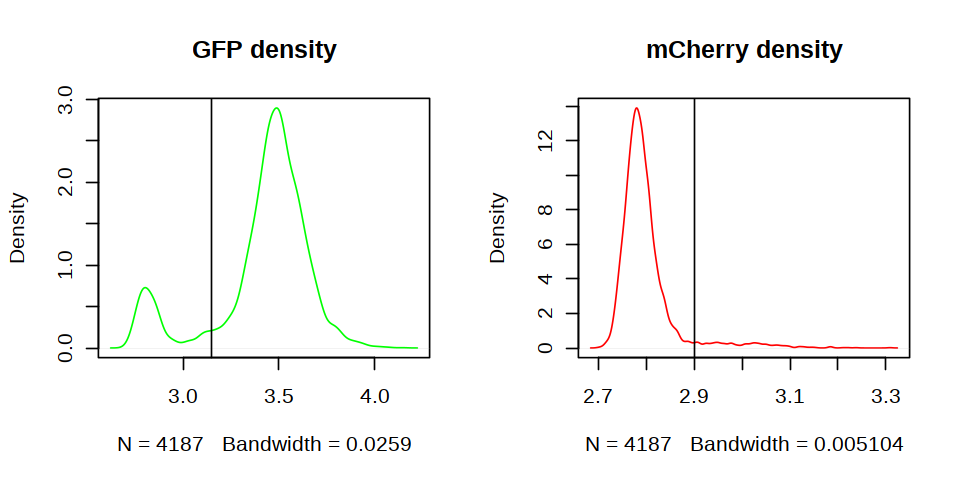

In [9]:
lin_trace_embryos = grep("lin",unique(mat_embexe@cell_metadata[names(mc_embexe@mc),"embryo"]),v = T)
cls_lin = names(mc_embexe@mc)[md_embexe[names(mc_embexe@mc),"embryo"] 
                              %in% lin_trace_embryos]

#########################################################################################################

FCS.df <- mat_embexe@cell_metadata[cls_lin,c("tdtomato_a","gfp_a")]
FCS.df <- FCS.df[!is.na(FCS.df$tdtomato_a),]
FCS.df$col <- mc_embexe@colors[mc_embexe@mc[rownames(FCS.df)]]
FCS.df$gfp_n <- FCS.df$gfp_a - min(FCS.df$gfp_a) 
FCS.df$tdtomato_n <- FCS.df$tdtomato_a - min(FCS.df$tdtomato_a) 
FCS.df <- FCS.df[!is.na(FCS.df$col),]

#########################################################################################################

plot_size(8,4)
par(mfrow = c(1,2))
plot(density(log10(FCS.df$gfp_n + 500)),col = "green", main = "GFP density")
abline(v = 3.15)

plot(density(log10(FCS.df$tdtomato_n + 500)),col = "red", main = "mCherry density")
abline(v = 2.9)

emb_cols <- mc_emb@color_key$color[1:38]
exe_cols <- mc@color_key$color[1:8]


cls_emb <- names(mc_embexe@mc)[mc_embexe@colors[mc_embexe@mc] %in% emb_cols]
cls_emb <- intersect(cls_emb, cls_lin)

cls_exe <- names(mc_embexe@mc)[mc_embexe@colors[mc_embexe@mc] %in% exe_cols]
cls_exe <- intersect(cls_exe, cls_lin)

In [10]:
gfp_positive <- rownames(FCS.df)[which(log10(FCS.df$gfp_n + 500) > 3.15)]
mCherry_positive <- rownames(FCS.df)[which(log10(FCS.df$tdtomato_n + 500) > 2.9)]

#########################################################################################################

gfp_positive_per_exe <- gfp_positive[gfp_positive %in% cls_exe]
gfp_positive_per_exe_per <- paste0(round(100*length(gfp_positive_per_exe)/length(cls_exe),2),"%",sep="")
message(sprintf("GFP+/ExE cells = %s", gfp_positive_per_exe_per))

gfp_positive_per_emb <- gfp_positive[gfp_positive %in% cls_emb]
gfp_positive_per_emb_per <- paste0(round(100*length(gfp_positive_per_emb)/length(cls_emb),2),"%",sep="")
message(sprintf("GFP+/Embryo cells = %s", gfp_positive_per_emb_per))

#########################################################################################################

mCherry_positive_per_exe <- mCherry_positive[mCherry_positive %in% cls_exe]
mCherry_positive_per_exe_per <- paste0(round(100*length(mCherry_positive_per_exe)/length(cls_exe),2),"%",sep="")
message(sprintf("mCherry+/ExE cells = %s", mCherry_positive_per_exe_per))

mCherry_positive_per_emb <- mCherry_positive[mCherry_positive %in% cls_emb]
mCherry_positive_per_emb_per <- paste0(round(100*length(mCherry_positive_per_emb)/length(cls_emb),2),"%",sep="")
message(sprintf("mCherry+/Embryo cells = %s", mCherry_positive_per_emb_per))

GFP+/ExE cells = 3.05%

GFP+/Embryo cells = 99.67%

mCherry+/ExE cells = 46.62%

mCherry+/Embryo cells = 0%



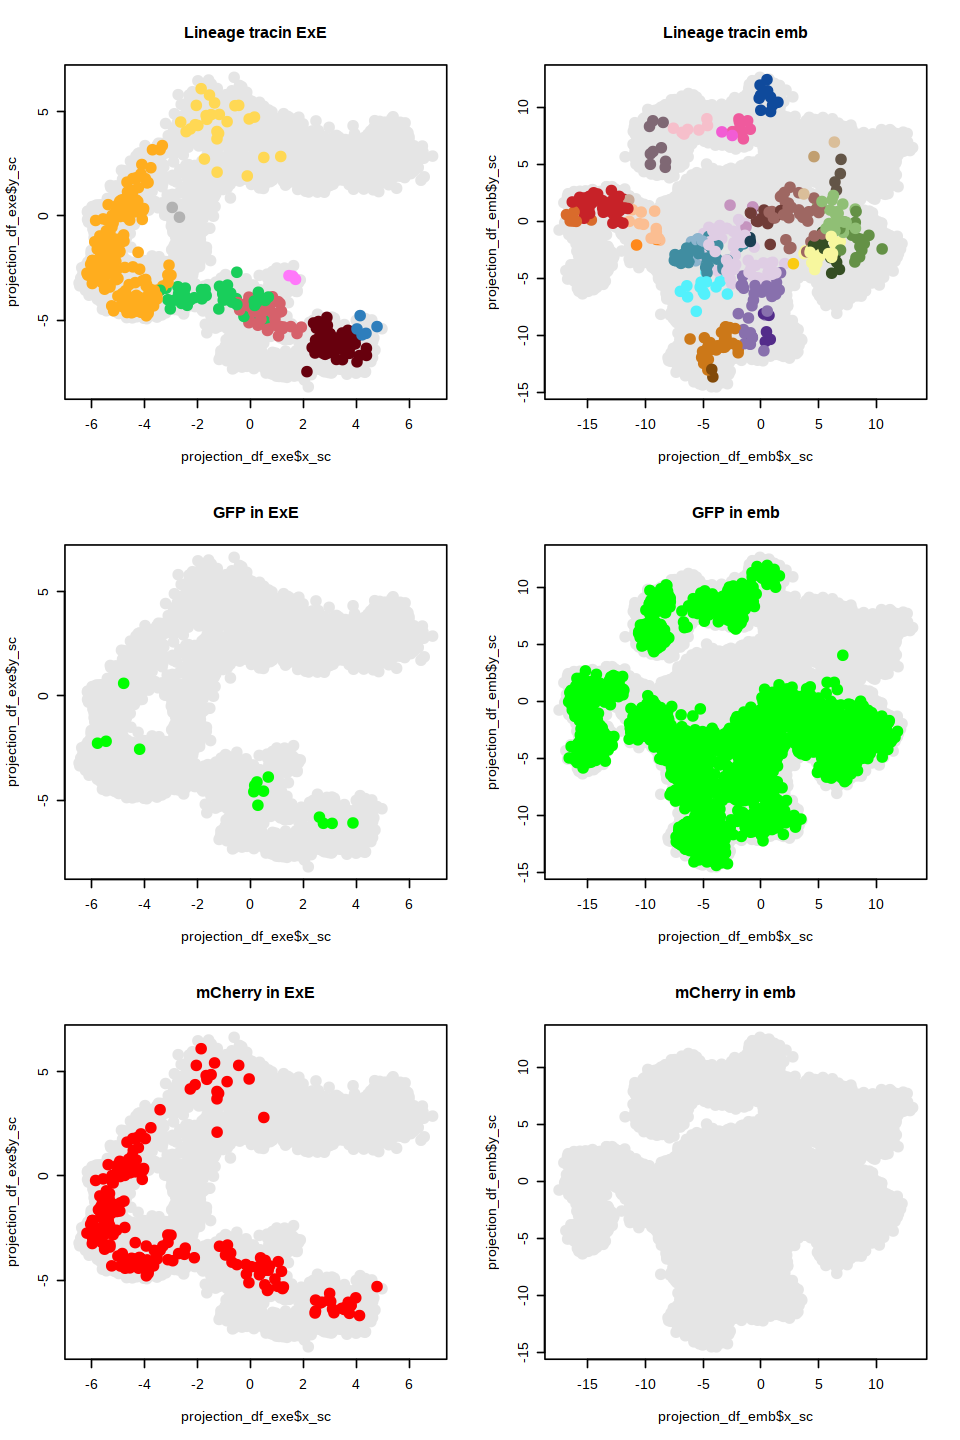

In [11]:
sc_col_exe <- mc@colors[mc@mc]
names(sc_col_exe) <- names(mc@mc)

sc_col_emb <- mc_emb@colors[mc_emb@mc]
names(sc_col_emb) <- names(mc_emb@mc)

projection_df <- data.frame("x_sc" = c(mc2d@sc_x,mc2d_emb@sc_x),
                            "y_sc" = c(mc2d@sc_y,mc2d_emb@sc_y),
                            "sc_col" = c(sc_col_exe,sc_col_emb))

projection_df$tissue <- ifelse(rownames(projection_df) %in% names(mc_emb@mc), yes = "emb", 
       ifelse(rownames(projection_df) %in% names(mc@mc), yes = "exe", no = "other"))
projection_df$lin_trace <- ifelse(rownames(projection_df) %in% cls_lin, yes = "lin_trace", no = FALSE)
projection_df$GFP <- ifelse(rownames(projection_df) %in% gfp_positive, yes =  "GFP", no = FALSE)
projection_df$mCherry <- ifelse(rownames(projection_df) %in% mCherry_positive, yes =  "mCherry", no = FALSE)

projection_df_exe <- projection_df %>% filter(tissue == "exe")
projection_df_emb <- projection_df %>% filter(tissue == "emb")

projection_df_lin_exe <- projection_df_exe %>% filter(lin_trace == "lin_trace")
projection_df_lin_emb <- projection_df_emb %>% filter(lin_trace == "lin_trace")

#########################################################################################################
plot_size(8,12)
# pdf("figs/EDF7d.pdf", width = 8, height = 12, useDingbats = F)
par(mfrow = c(3,2))
plot(projection_df_exe$x_sc,projection_df_exe$y_sc,col="#E5E5E5",pch = 19, cex = 1.5, main = "Lineage tracin ExE")
points(projection_df_exe[projection_df$lin_trace == 'lin_trace',"x_sc"],
       projection_df_exe[projection_df$lin_trace == 'lin_trace',"y_sc"],
       pch = 19, cex = 1.5, col = projection_df_exe[projection_df$lin_trace == 'lin_trace',"sc_col"])

plot(projection_df_emb$x_sc,projection_df_emb$y_sc,col="#E5E5E5",pch = 19, cex = 1.5, main = "Lineage tracin emb")
points(projection_df_emb[projection_df$lin_trace == 'lin_trace',"x_sc"],
       projection_df_emb[projection_df$lin_trace == 'lin_trace',"y_sc"],
       pch = 19, cex = 1.5, col = projection_df_emb[projection_df$lin_trace == 'lin_trace',"sc_col"])

#########################################################################################################

plot(projection_df_exe$x_sc,projection_df_exe$y_sc,col="#E5E5E5",pch = 19, cex = 1.5, main = "GFP in ExE")
points(projection_df_lin_exe[projection_df_lin_exe$GFP == 'GFP',"x_sc"],
       projection_df_lin_exe[projection_df_lin_exe$GFP == 'GFP',"y_sc"],
       pch = 19, cex = 1.5, col = "green")

plot(projection_df_emb$x_sc,projection_df_emb$y_sc,col="#E5E5E5",pch = 19, cex = 1.5, main = "GFP in emb")
points(projection_df_lin_emb[projection_df_lin_emb$GFP == 'GFP',"x_sc"],
       projection_df_lin_emb[projection_df_lin_emb$GFP == 'GFP',"y_sc"],
       pch = 19, cex = 1.5, col = "green")

#########################################################################################################

plot(projection_df_exe$x_sc,projection_df_exe$y_sc,col="#E5E5E5",pch = 19, cex = 1.5, main = "mCherry in ExE")
points(projection_df_lin_exe[projection_df_lin_exe$mCherry == 'mCherry',"x_sc"],
       projection_df_lin_exe[projection_df_lin_exe$mCherry == 'mCherry',"y_sc"],
       pch = 19, cex = 1.5, col = "red")

plot(projection_df_emb$x_sc,projection_df_emb$y_sc,col="#E5E5E5",pch = 19, cex = 1.5, main = "mCherry in emb")
points(projection_df_lin_emb[projection_df_lin_emb$mCherry == 'mCherry',"x_sc"],
       projection_df_lin_emb[projection_df_lin_emb$mCherry == 'mCherry',"y_sc"],
       pch = 19, cex = 1.5, col = "red")
# dev.off()

## EDF 7-e

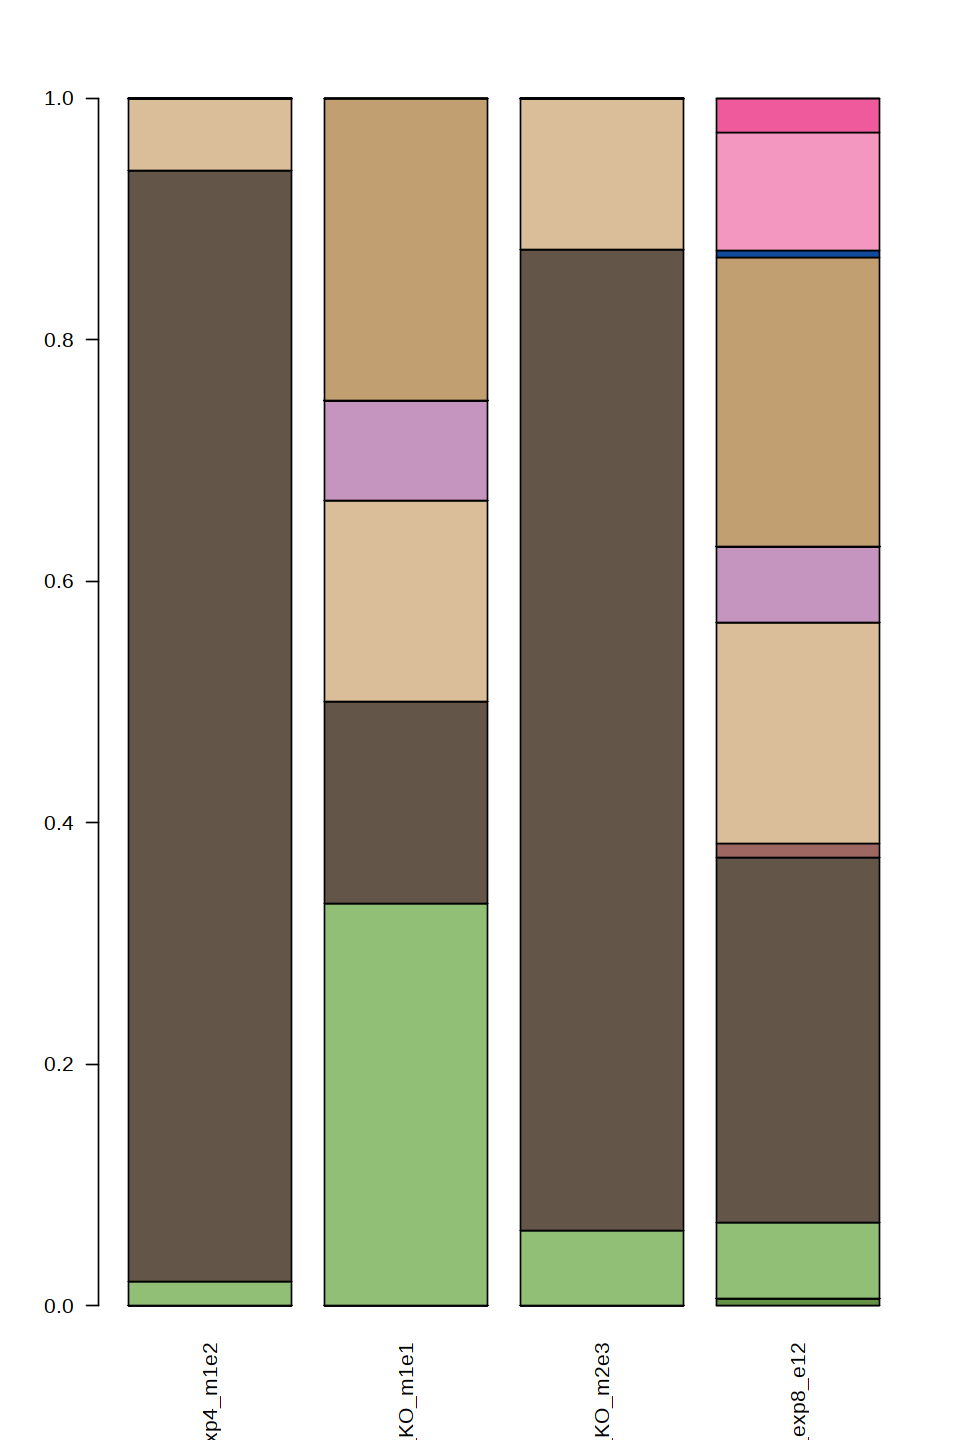

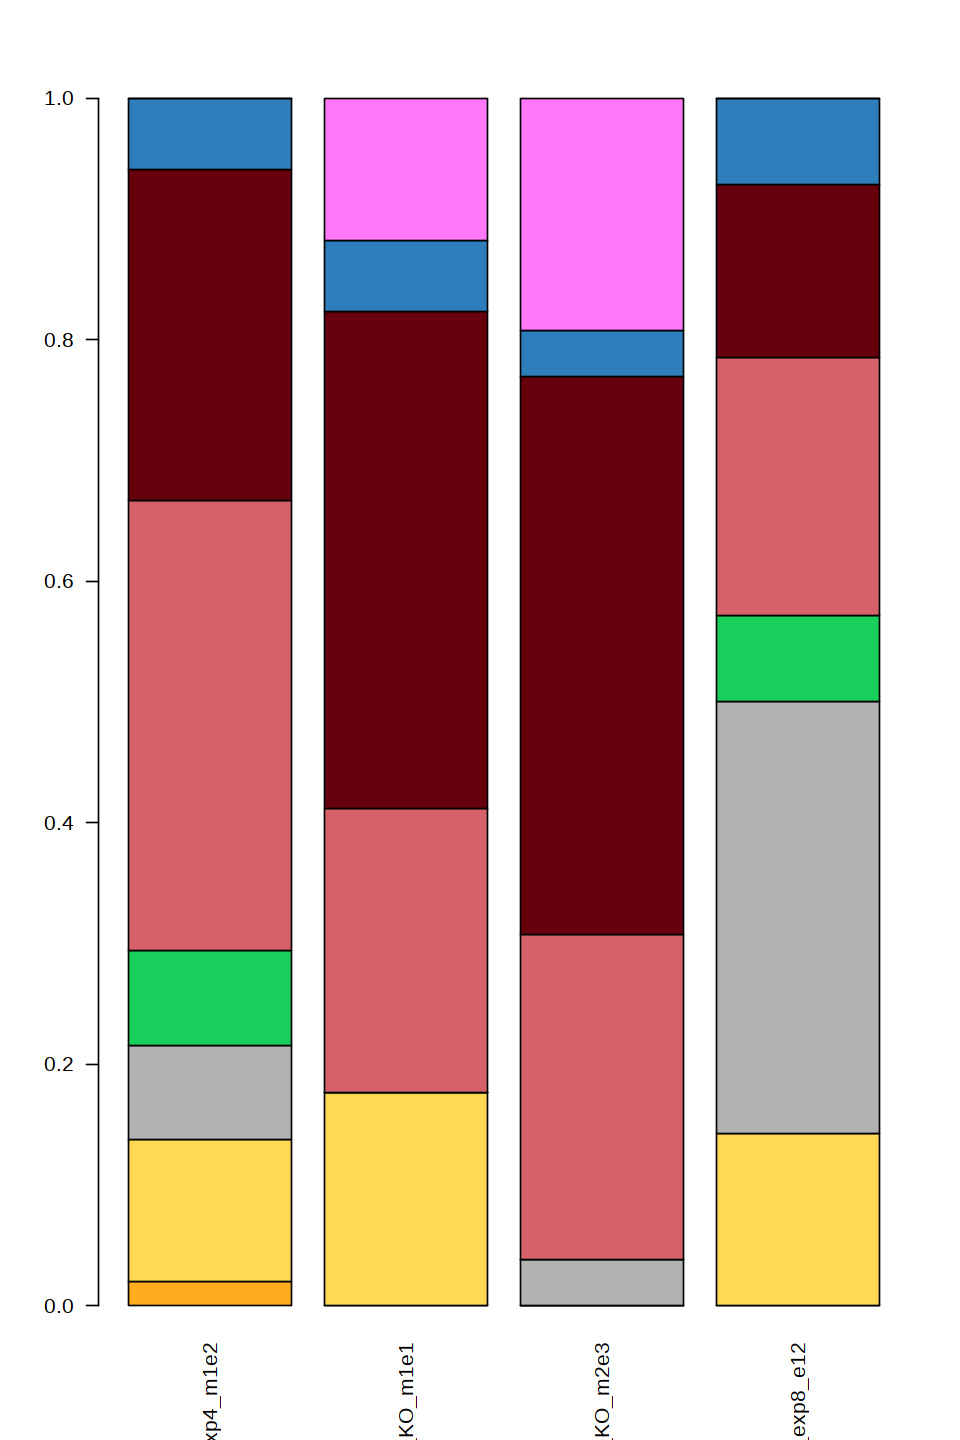

In [12]:
emb_cols <- mc_emb@color_key$color[1:38]
exe_cols <- mc@color_key$color[1:8]

# KO cell type frequencies:
embryo_to_col_ko <- table(factor(x = elf5_annotations[elf5_annotations$embryo %in% ko_embs,"cell_type_color"],
                                 levels = c(emb_cols,exe_cols)),
                          elf5_annotations[elf5_annotations$embryo %in% ko_embs,"embryo"])

embryo_to_col_ko_emb <- embryo_to_col_ko[emb_cols,] # subset of embryonic cell types
embryo_to_col_ko_exe <- embryo_to_col_ko[exe_cols,] # subset of ExE cell types

embryo_to_col_ko_emb_n <- t(t(embryo_to_col_ko_emb)/colSums(embryo_to_col_ko_emb))
embryo_to_col_ko_exe_n <- t(t(embryo_to_col_ko_exe)/colSums(embryo_to_col_ko_exe))

barplot(embryo_to_col_ko_emb_n,
        col = rownames(embryo_to_col_ko_emb_n),
        las = 2)

barplot(embryo_to_col_ko_exe_n,
        col = rownames(embryo_to_col_ko_exe_n),
        las = 2)

## EDF 7g

In [13]:
match_df_elf5 = read.table("./data/elf5_embexe/time_match/time_match_summary.txt", header = T)
match_df_elf5 = match_df_elf5 %>% filter(embryo %in% ko_embs)

In [14]:
ct_to_col

Chorion  Chorion progenitors Intermediate Chorion 
           "#ffad1e"            "#ffd854"            "#b2b2b2" 
             SpT-Gly      EPC progenitors      TGC progenitors 
           "#19ce5b"            "#d6616b"            "#67000d" 
               p-TGC              SpA-TGC       Maternal cells 
           "#2e7ebc"            "#ff78fa"             "gray40"

In [15]:
ct = "Chorion"

wt_age = read.table('data/embexe.transcriptional_rank_developmental_time_with_age_group.tsv',sep ='\t',h = T)

min_rank = min(wt_age[ wt_age$transcriptional_rank %in% match_df_elf5$best_rank_query,"transcriptional_rank"])
max_rank = max(wt_age[ wt_age$transcriptional_rank %in% match_df_elf5$best_rank_query,"transcriptional_rank"])
ranks_to_include = wt_age %>% filter(transcriptional_rank >= min_rank & transcriptional_rank <= max_rank) %>% pull(transcriptional_rank)

n_exe_cells_per_embryo = table(md[md$transcriptional_rank %in% ranks_to_include,"transcriptional_rank"])
embryos_included = names(n_exe_cells_per_embryo)[n_exe_cells_per_embryo >= 14]

# Elf5 frequency
cells_included = rownames(mat_embexe@cell_metadata)[mat_embexe@cell_metadata$transcriptional_rank %in% embryos_included]
wt_ct_ag_exe = table(mat_embexe@cell_metadata[cells_included,"transcriptional_rank"],factor(x = col_to_ct[mc@colors[mc@mc[cells_included]]],levels = mc@color_key$group))
wt_ct_ag_exe_n = wt_ct_ag_exe/rowSums(wt_ct_ag_exe)

# wt_chorion_fraction = rowSums(wt_ct_ag_exe_n[,ct])
# elf5_chorion_fraction = colSums( embryo_to_col_ko_exe_n[ct_to_col[ct],])

wt_chorion_fraction = wt_ct_ag_exe_n[,ct]
elf5_chorion_fraction = embryo_to_col_ko_exe_n[ct_to_col[ct],]

# downsample to minimal cell count in one of the Elf5 KOs
# set.seed(123)
# wt_ct_ag_exe_ds = as.matrix(t(scm_downsamp(umis = t(as.matrix(as.data.frame.matrix(wt_ct_ag_exe))), n = 14)))
# wt_ct_ag_exe_ds_n = wt_ct_ag_exe_ds/rowSums(wt_ct_ag_exe_ds)
# wt_chorion_fraction_ds = rowSums(wt_ct_ag_exe_ds_n[,c("Chorion","Chorion progenitors")])
# wt_chorion_fraction_ds = wt_ct_ag_exe_ds_n[,c("Chorion")]

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



png 
  2

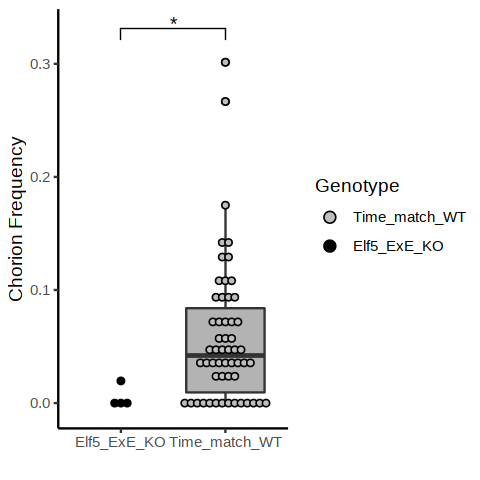

In [16]:
wilcox_test_chorion_frequency = wilcox.test(x = elf5_chorion_fraction, y = wt_chorion_fraction)
p_val = wilcox_test_chorion_frequency$p.value

p_to_signif = function(v) {
    v_signif = sapply(v,function(x) {
      
      if(x >= 0.05) {
        a = "ns"
      } else if (x >= 0.005) {
        a = "*"
      } else {
        a = "**"
      }
      return(a)
    })
    return(v_signif)
}

df_plot = data.frame(frequency = c(wt_chorion_fraction,elf5_chorion_fraction),
                     genotype = c(rep("Time_match_WT",length(wt_chorion_fraction)),rep("Elf5_ExE_KO",4)))

stat_comparison = data.frame(group1 = c("Time_match_WT"),
                             group2 = c("Elf5_ExE_KO"),
                             p_val = p_val,
                             p.signif = p_to_signif(p_val))

options(repr.plot.width=4, repr.plot.height=4)
f_wt = df_plot$genotype == "Time_match_WT"
p = ggplot(data = df_plot,aes(x = genotype,y = frequency)) + 
        geom_boxplot(data = df_plot[f_wt,],fill = "gray70") +
        geom_dotplot(binaxis='y', stackdir='center', dotsize=0.5,aes(fill = genotype)) + 
        ggpubr::stat_pvalue_manual(stat_comparison,y.position = max(df_plot$frequency)*1.1,step.increase = 0.1,label = "p.signif") +
        xlab("") + 
        ylab(sprintf("%s Frequency",ct)) + 
        scale_fill_manual(values = c("Time_match_WT" = "gray","Elf5_ExE_KO" = "black"),name = "Genotype")
print(p)

pdf("./figs/EDF7g_stat.pdf",6,6,useDingbats = F)
print(p)
dev.off()

## EDF 7-h

In [17]:
elf5_score_df <- data.frame("cell" = names(cmp_annot$query_cls_col),
                            "embryo" = md_elf5[names(cmp_annot$query_cls_col),"embryo"],
                            "cell_type_color" = cmp_annot$query_cls_col)

elf5_score_df$type <- ifelse(elf5_score_df$embryo %in% ko_embs, "KO", "other")

col_to_ct =  mc_embexe@color_key$group
names(col_to_ct) = mc_embexe@color_key$color
ct_to_col = mc_embexe@color_key$color
names(ct_to_col) = mc_embexe@color_key$group

elf5_score_df$cell_type <- col_to_ct[elf5_score_df$cell_type_color]

elf5_score_df_pinch <- elf5_score_df[(elf5_score_df$type == "KO") & (elf5_score_df$cell_type_color %in% exe_cols),]

tsc_gm <- read.table("data/tsc_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
tgc_gm <- read.table("data/tgc_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
spt_gm <- read.table("data/spt_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
chorion_gm <- read.table("data/chorion_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]

elf5_score_df_pinch$tgc_score <- log2(colSums(as.matrix(mat_elf5@mat[tgc_gm,elf5_score_df_pinch$cell]))/colSums(as.matrix(mat_elf5@mat[,elf5_score_df_pinch$cell])) + 1e-3)
elf5_score_df_pinch$spt_score <- log2(colSums(as.matrix(mat_elf5@mat[spt_gm,elf5_score_df_pinch$cell]))/colSums(as.matrix(mat_elf5@mat[,elf5_score_df_pinch$cell])) + 1e-3)
elf5_score_df_pinch$chp_score <- log2(colSums(as.matrix(mat_elf5@mat[tsc_gm,elf5_score_df_pinch$cell]))/colSums(as.matrix(mat_elf5@mat[,elf5_score_df_pinch$cell])) + 1e-3)
elf5_score_df_pinch$chor_score <- log2(colSums(as.matrix(mat_elf5@mat[chorion_gm,elf5_score_df_pinch$cell]))/colSums(as.matrix(mat_elf5@mat[,elf5_score_df_pinch$cell])) + 1e-3)

elf5_score_df_pinch_Chorion <- subset(elf5_score_df_pinch,elf5_score_df_pinch$cell_type_color %in% c("#ffad1e","#ffd854","#b2b2b2"))
elf5_score_df_pinch_EPC <- subset(elf5_score_df_pinch,elf5_score_df_pinch$cell_type_color %in% c("#19ce5b","#d6616b","#67000d"))

In [18]:
wt_score_df <- data.frame(row.names =names(mc@mc), "cell" = names(mc@mc),
                            "embryo" = md[names(mc@mc),"embryo"],
                            "cell_type_color" = mc@colors[mc@mc])

wt_score_df$tgc_score <- log2(colSums(as.matrix(mat@mat[tgc_gm,wt_score_df$cell]))/colSums(as.matrix(mat@mat[,wt_score_df$cell])) + 1e-3)
wt_score_df$spt_score <- log2(colSums(as.matrix(mat@mat[spt_gm,wt_score_df$cell]))/colSums(as.matrix(mat@mat[,wt_score_df$cell])) + 1e-3)
wt_score_df$chp_score <- log2(colSums(as.matrix(mat@mat[tsc_gm,wt_score_df$cell]))/colSums(as.matrix(mat@mat[,wt_score_df$cell])) + 1e-3)
wt_score_df$chor_score <- log2(colSums(as.matrix(mat@mat[chorion_gm,wt_score_df$cell]))/colSums(as.matrix(mat@mat[,wt_score_df$cell])) + 1e-3)

wt_score_df_Chorion <- subset(wt_score_df,wt_score_df$cell_type_color %in% c("#ffad1e","#ffd854","#b2b2b2"))
wt_score_df_EPC <- subset(wt_score_df,wt_score_df$cell_type_color %in% c("#19ce5b","#d6616b","#67000d"))

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.0 GiB"
Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.0 GiB"
Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.0 GiB"
Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.0 GiB"


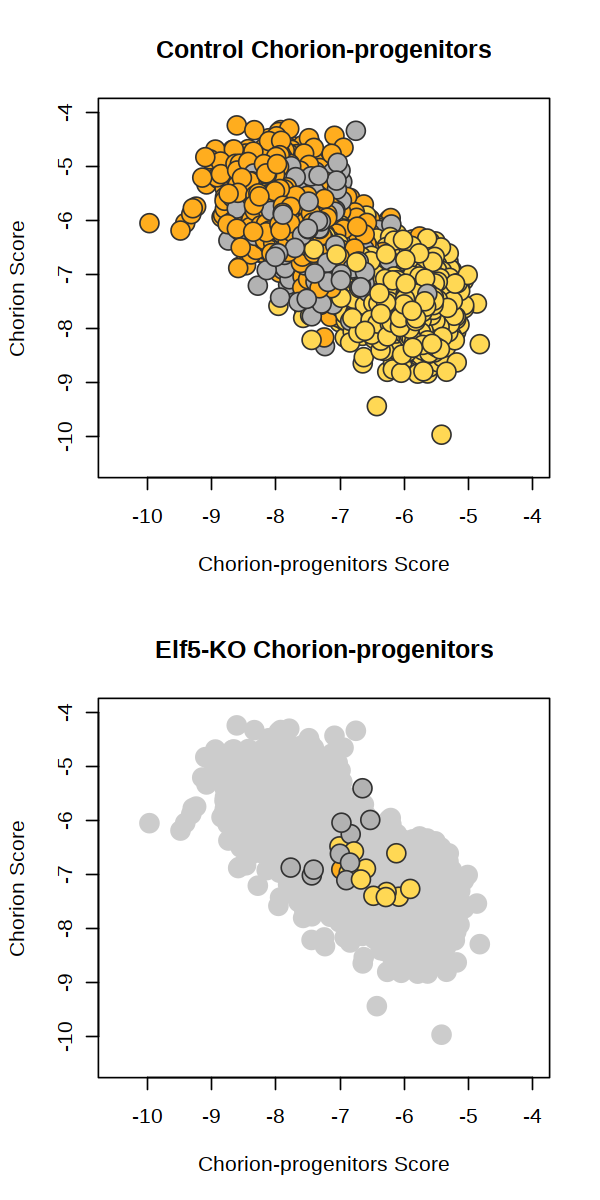

In [19]:
plot_size(5,10)
par(mfrow=c(2,1))

## Control Chorion-score
plot(x = wt_score_df_Chorion$chp_score,
       y = wt_score_df_Chorion$chor_score,
       pch = 21, cex = 2,
       bg = wt_score_df_Chorion$cell_type_color,
       col="#313131",
       ylim = c(-10.5,-4), xlim = c(-10.5,-4),
       main = "Control Chorion-progenitors",
       xlab = "Chorion-progenitors Score", 
       ylab = "Chorion Score")

## KO Chorion-score
plot(x = wt_score_df_Chorion$chp_score,
       y = wt_score_df_Chorion$chor_score,
       pch = 19, 
       col = "#CCCCCC",
       cex = 2,
       ylim = c(-10.5,-4), xlim = c(-10.5,-4),
       main = "Elf5-KO Chorion-progenitors",
       xlab = "Chorion-progenitors Score", 
       ylab = "Chorion Score")

points(x = elf5_score_df_pinch_Chorion$chp_score,
       y = elf5_score_df_pinch_Chorion$chor_score,
       cex = 2,
       col="#313131",
       pch = 21,
       bg = elf5_score_df_pinch_Chorion$cell_type_color)

## EDF 7-i

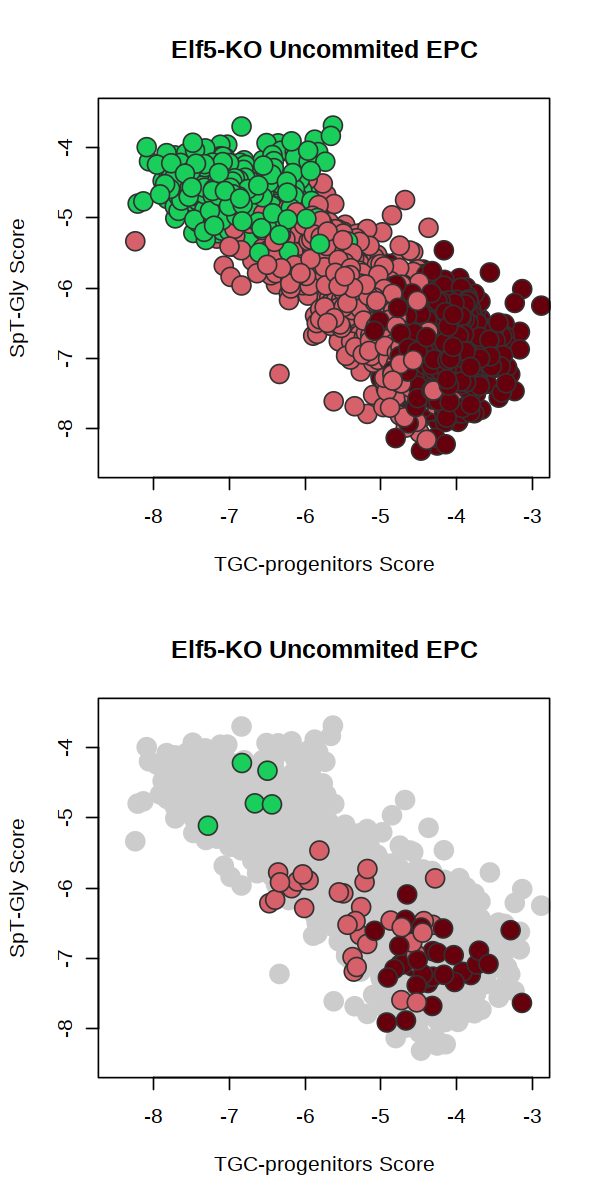

In [20]:
plot_size(5,10)
par(mfrow=c(2,1))

## Control Chorion-score
plot(x = wt_score_df_EPC$tgc_score,
       y = wt_score_df_EPC$spt_score,
       pch = 21, cex = 2,
       bg = wt_score_df_EPC$cell_type_color,
       col="#313131",
       ylim = c(-8.5,-3.5), xlim = c(-8.5,-3),
       main = "Elf5-KO Uncommited EPC",
       xlab = "TGC-progenitors Score", 
       ylab = "SpT-Gly Score")

## KO Chorion-score
plot(x = wt_score_df_EPC$tgc_score,
       y = wt_score_df_EPC$spt_score,
       pch = 19, 
       col = "#CCCCCC",
       cex = 2,
       ylim = c(-8.5,-3.5), xlim = c(-8.5,-3),
       main = "Elf5-KO Uncommited EPC",
       xlab = "TGC-progenitors Score", 
       ylab = "SpT-Gly Score")

points(x = elf5_score_df_pinch_EPC$tgc_score,
       y = elf5_score_df_pinch_EPC$spt_score,
       cex = 2,
       col="#313131",
       pch = 21,
       bg = elf5_score_df_pinch_EPC$cell_type_color)

In [21]:
load("data/elf5_embexe/color_annotation/cmp_annot.Rda")
mat_wt = scdb_mat("embexe")
mc_wt = scdb_mc("embexe_recolored")

mat_exe <- scdb_mat("exe")
mc_exe <- scdb_mc("exe")
md_exe <- mat_exe@cell_metadata[names(mc_exe@mc),]

mat_emb <- scdb_mat("emb")
mc_emb <- scdb_mc("emb")
md_emb <- mat_emb@cell_metadata[names(mc_emb@mc),]

mat_elf5 = scdb_mat("elf5")
mat_elf5_embexe = scdb_mat("elf5_embexe")
md_elf5 <- mat_elf5@cell_metadata

ko_embs <- c("elf5_exp6_KO_m1e1","elf5_exp4_m1e2","elf5_exp6_KO_m2e3","elf5_ko_exp8_e12")

ko_cls <- rownames(mat_elf5@cell_metadata)[mat_elf5@cell_metadata$embryo %in% ko_embs]
ko_cls <- ko_cls[ko_cls %in% names(cmp_annot$query_cls_col)]

####################################################################################################
double_positive_cells <- read.csv(file = "data/elf5_embexe/double_pos_cells.csv")[,2]
####################################################################################################

# KO emb
epiblast_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#635547"]
primitive_streak_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#DABE99"]

# KO EXE
chp_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#ffd854"]
chp_ko <- chp_ko[chp_ko %in% double_positive_cells]

chorion_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#ffad1e"]
chorion_ko <- chorion_ko[chorion_ko %in% double_positive_cells]

epc_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#d6616b"]
epc_ko <- epc_ko[epc_ko %in% double_positive_cells]

tsc2_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#b2b2b2"]
tsc2_ko <- tsc2_ko[tsc2_ko %in% double_positive_cells]

spt_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#19ce5b"]
spt_ko <- spt_ko[spt_ko %in% double_positive_cells]

tgc_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#67000d"]
tgc_ko <- tgc_ko[tgc_ko %in% double_positive_cells]
####################################################################################################
# WT emb
epiblast_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#635547"]
primitive_streak_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#DABE99"]

# WT EXE
chp_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#ffd854"]
chorion_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#ffad1e"]
epc_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#d6616b"]
tsc2_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#b2b2b2"]
spt_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#19ce5b"]
tgc_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#67000d"]

####################################################################################################
all_wt_cls <- c(epiblast_cls,
                chp_cls,
                primitive_streak_cls,
                epc_cls,
                tsc2_cls,
                spt_cls,
                tgc_cls,
                chorion_cls)

all_ko_cls <- c(epiblast_ko,
                chp_ko,
                primitive_streak_ko,
                epc_ko,
                tsc2_ko,
                spt_ko,
                tgc_ko,
                chorion_ko)

cls <- c(all_wt_cls,all_ko_cls)
cls <- intersect(cls, colnames(mat_elf5_embexe@mat))

In [22]:
egc <- mat_elf5_embexe@mat[,cls]
legc_n <- t(t(egc)/colSums(egc))

png 
  2

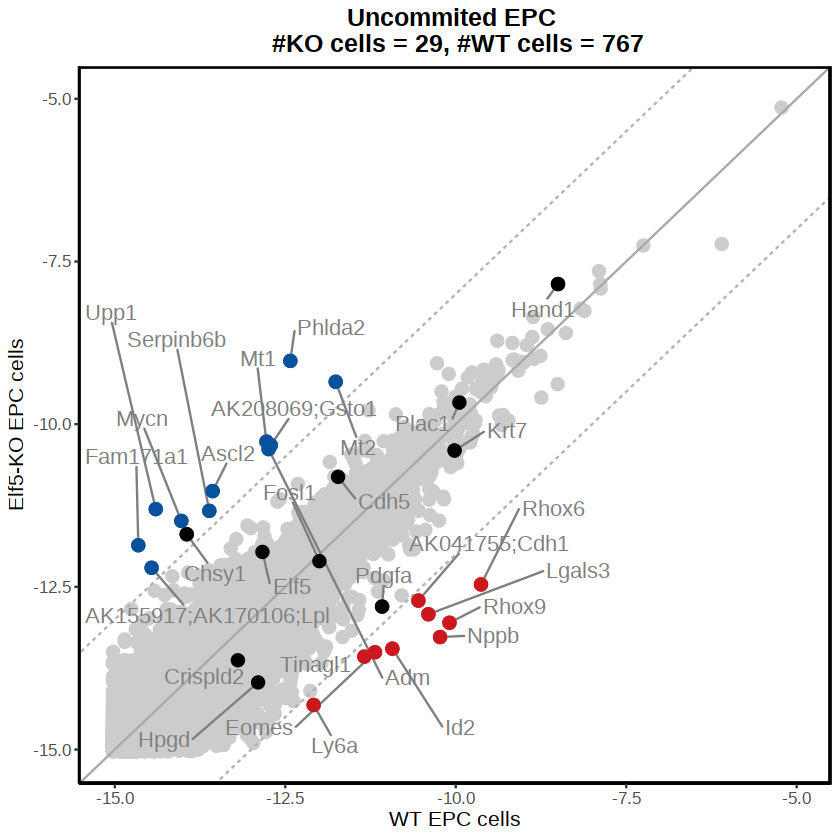

In [23]:
options(repr.plot.width=7, repr.plot.height=7)

ct = "epc"
fc = 2
reg = 3e-5

wt_cels <- get(x = sprintf("%s_cls", ct),envir = .GlobalEnv)
ko_cels <- get(x = sprintf("%s_ko", ct),envir = .GlobalEnv)

dge1 <- matrix(rowMeans(legc_n[,wt_cels]),dimnames = list(c(row.names(legc_n))))
dge2 <- matrix(rowMeans(legc_n[,ko_cels]),dimnames = list(c(row.names(legc_n))))

title.nm <- "Uncommited EPC \n #KO cells = 29, #WT cells = 767"

temp <- cbind(dge2[,1],dge1[,1])
colnames(temp) <- c("gexp.2", "gexp.1")
temp <- as.data.frame(temp)
temp$log.2 <- log2(temp$gexp.2 + reg)
temp$log.1 <- log2(temp$gexp.1 + reg)

temp$diff.2 <- log2(temp$gexp.2 + reg) - log2(temp$gexp.1 + reg)
temp$diff.1 <- log2(temp$gexp.1 + reg) - log2(temp$gexp.2 + reg)

up <- rownames(temp)[temp$diff.1 > fc]
dn <- rownames(temp)[temp$diff.2 > fc]

# high_gexp <- rownames(temp)[temp$log.1 > -14]
# up <- intersect(up,high_gexp)
# dn <- intersect(dn,high_gexp)

# up <- c("Pdgfa","Rhox6","Rhox9") #pTE
# dn <- c("Adm", "Chsy1", "Ascl2", "Phlda2") # ChP
mark <- c("Fosl1", "Cdh5", "Elf5","Hpgd",
          "Hand1","Pdgfa","Crispld2","Chsy1","Krt7","Plac1")

rnms <- rownames(temp)
rnms <- subset(rnms , rnms %in% c(up,dn,mark))

temp$log <- NA
temp$log[rownames(temp) %in% dn] <- "dn"
temp$log[rownames(temp) %in% up] <- "up"
temp$log[rownames(temp) %in% mark] <- "mark"
temp$log[which(is.na(temp$log))] <- "n"

xlims <- c(log2(reg),-5)
ylims <- c(log2(reg),-5)

pa <- ggplot(data = temp,aes(log.2,log.1,col=log)) +
  geom_point(size = 3) +
  geom_abline(slope = 1,col="darkgrey") +
geom_abline(slope = 1,intercept = fc, col = "gray70",linetype = 'dashed') +
          geom_abline(slope = 1,intercept = -fc, col = "gray70",linetype = 'dashed') +
  ggtitle(title.nm) +
    xlim(xlims) + 
    ylim(ylims) + 
 ylab(sprintf("Elf5-KO %s cells", toupper(ct))) +
  xlab(sprintf("WT %s cells", toupper(ct))) +
    theme(plot.title = element_text(face = "bold",hjust = 0.5)) +

  scale_color_manual(values = c("up"="#08519C",
                                "dn"="#CB181D",
                                "mark"="black",
                                "n"="#CCCCCC"))

p1 <- pa  + geom_text_repel(data=subset(temp, rownames(temp) %in% rnms),
                            aes(log.2,
                                log.1,
                                label=rnms, 
                                col  = "#000000",
                                size = 5), force = 100,max.overlaps = 100) +

            geom_point(data=subset(temp, rownames(temp) %in% rnms),
                     aes(log.2,log.1), size = 3) +

            theme(legend.position = "none", text = element_text(size = 12),
                panel.border = element_rect(fill=NA, size = 1))

pdf("figs/EDF8I.pdf", width = 7, height = 7)
print(p1)
dev.off()

print(p1)

## EDF 7-g

In [24]:
match_df_elf5 = read.table("./data/elf5_embexe/time_match/time_match_summary.txt", header = T)
match_df_elf5 = match_df_elf5 %>% filter(embryo %in% ko_embs)
matching_elf5_embs = unique(mat_embexe@cell_metadata[ mat_embexe@cell_metadata$transcriptional_rank %in% c(107,143,176,141),"embryo"])
# matching_elf5_embs = unique(mat_embexe@cell_metadata[ mat_embexe@cell_metadata$transcriptional_rank %in% match_df_elf5$best_rank_query,"embryo"])
matching_elf5_cls = rownames(mat_embexe@cell_metadata)[ mat_embexe@cell_metadata$embryo %in% matching_elf5_embs]
matching_elf5_cls = intersect(matching_elf5_cls, colnames(mat_elf5_embexe@mat))
matching_elf5_cls = intersect(matching_elf5_cls, names(mc_embexe@mc))

In [25]:
ko_vs_ct = table(elf5_score_df_pinch[elf5_score_df_pinch$cell,"embryo"],
                     factor(x = cmp_annot$query_cls_col[elf5_score_df_pinch$cell],
                            levels = mc_embexe@color_key$color[43:48]))

pool_ko_ct_comp = colSums(ko_vs_ct)/sum(colSums(ko_vs_ct))

In [26]:
match_vs_ct = table(mat_embexe@cell_metadata[matching_elf5_cls,"transcriptional_rank"],
                     factor(x = mc_embexe@colors[mc_embexe@mc[matching_elf5_cls]],
                            levels = mc_embexe@color_key$color[43:48]))

pool_match_ct_comp = colSums(match_vs_ct)/sum(colSums(match_vs_ct))

In [27]:
pool_df = data.frame(Elf5_ExE_KO = pool_ko_ct_comp, 
                     Time_match_WT = pool_match_ct_comp,
                    col = names(pool_match_ct_comp))
pool_df_long = data.frame(tidyr::pivot_longer(data = pool_df, cols = c(1:2)))
pool_df_long$col <- factor(pool_df_long$col, levels = rev(mc_embexe@color_key$color[c(43:48)]))
head(pool_df_long)


,col,name,value
,<fct>,<chr>,<dbl>
1,#ffad1e,Elf5_ExE_KO,0.01052632
2,#ffad1e,Time_match_WT,0.09090909
3,#ffd854,Elf5_ExE_KO,0.11578947
4,#ffd854,Time_match_WT,0.76136364
5,#b2b2b2,Elf5_ExE_KO,0.10526316
6,#b2b2b2,Time_match_WT,0.06250000


png 
  2

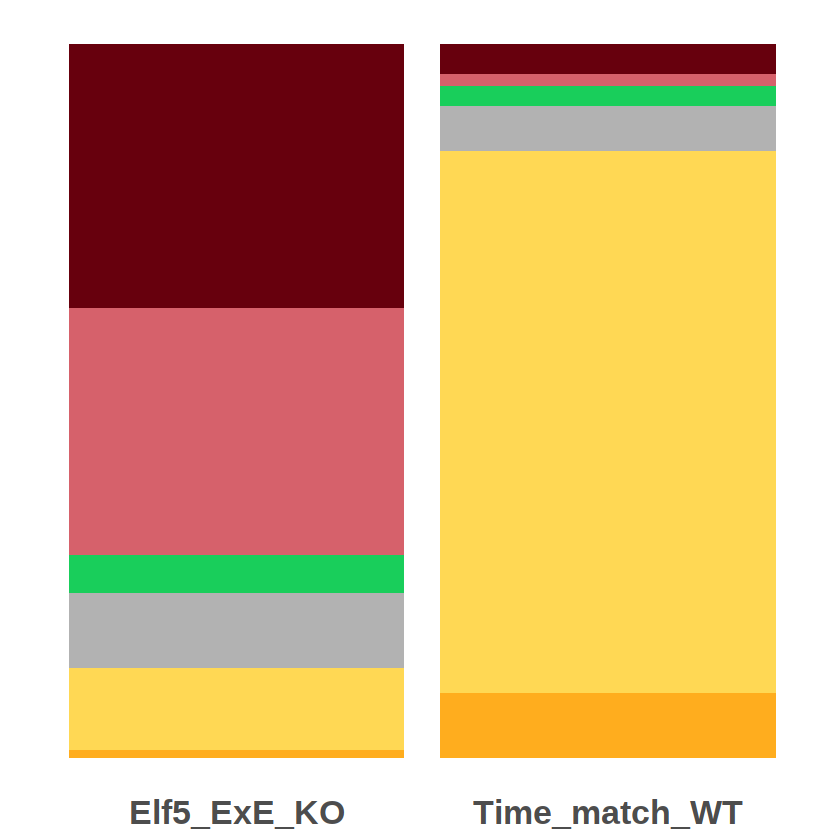

In [28]:
ggplot(pool_df_long, aes(name, value, fill = col)) +
  geom_col() +
  scale_fill_identity() +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.ticks = element_blank(),
        axis.line = element_blank(),
        axis.text.y = element_blank(),
        axis.text.x = element_text(face = "bold",size = 20),
        axis.title = element_blank(),
        panel.grid = element_blank(),panel.border = element_blank(), legend.position="None")

pdf("./figs/EDF7g.pdf",width = 6,height = 6, useDingbats = F)
ggplot(pool_df_long, aes(name, value, fill = col)) +
  geom_col() +
  scale_fill_identity() +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.ticks = element_blank(),
        axis.line = element_blank(),
        axis.text.y = element_blank(),
        axis.text.x = element_text(face = "bold",size = 20),
        axis.title = element_blank(),
        panel.grid = element_blank(),panel.border = element_blank(), legend.position="None")
dev.off()